# Workshop 1: Transfer Learning จาก VGG

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## เตรียมข้อมูล

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Deep Learning/tran dog cat/train', 
                                              target_size=(64,64), batch_size=32, class_mode='binary')

Found 321 images belonging to 2 classes.


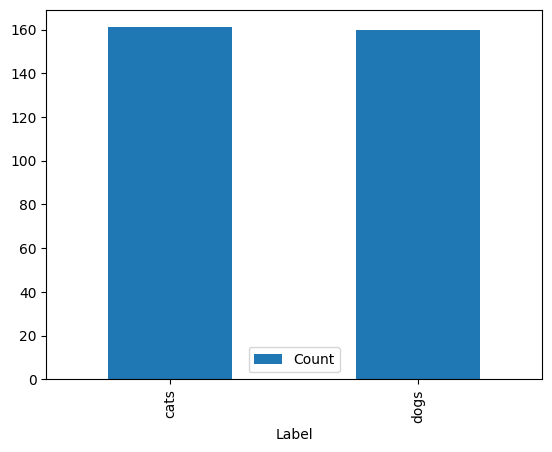

In [9]:
ids, counts = np.unique(train_set.classes, return_counts=True)
label_names = [k for k in train_set.class_indices]

df_train_labels = pd.DataFrame({'Label':label_names, 'Count':counts})
df_train_labels.set_index('Label', inplace=True)
df_train_labels.plot.bar()
plt.show()

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Deep Learning/tran dog cat/test', 
                                            target_size=(64,64), batch_size=32, class_mode='binary')

Found 176 images belonging to 2 classes.


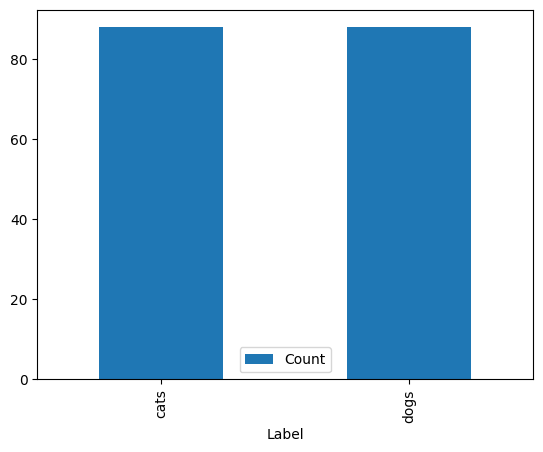

In [10]:
ids, counts = np.unique(test_set.classes, return_counts=True)
label_names = [k for k in test_set.class_indices]

df_test_labels = pd.DataFrame({'Label':label_names, 'Count':counts})
df_test_labels.set_index('Label', inplace=True)
df_test_labels.plot.bar()
plt.show()

## สร้าง Model

In [11]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))

base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [12]:
model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,977,089
Trainable params: 14,977,089
Non-trainable params: 0
_________________________________________________________________


In [13]:
for layer in model.layers:
  print('{:12} {}'.format(layer.name, layer.trainable))

vgg16        True
flatten      True
dense        True
dense_1      True


In [14]:
print("Trainable.\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable.
---
block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


In [15]:
base_model.trainable = False

In [16]:
print("Trainable.\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable.
---
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,977,089
Trainable params: 262,401
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile และ Train

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set, validation_data=test_set, epochs=20, verbose=1, callbacks=[es, mc])

end = time.time()
print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.6199
Epoch 1: val_accuracy improved from -inf to 0.71591, saving model to best_model.h5
11/11 [==============================] - 132s 13s/step - loss: 0.6669 - accuracy: 0.6199 - val_loss: 0.5361 - val_accuracy: 0.7159
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.7819
Epoch 2: val_accuracy improved from 0.71591 to 0.76705, saving model to best_model.h5
11/11 [==============================] - 28s 3s/step - loss: 0.4382 - accuracy: 0.7819 - val_loss: 0.4898 - val_accuracy: 0.7670
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8536
Epoch 3: val_accuracy did not improve from 0.76705
11/11 [==============================] - 28s 3s/step - loss: 0.3680 - accuracy: 0.8536 - val_loss: 0.4957 - val_accuracy: 0.7557
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8816
Epoch 4: val_ac

score = 0.778


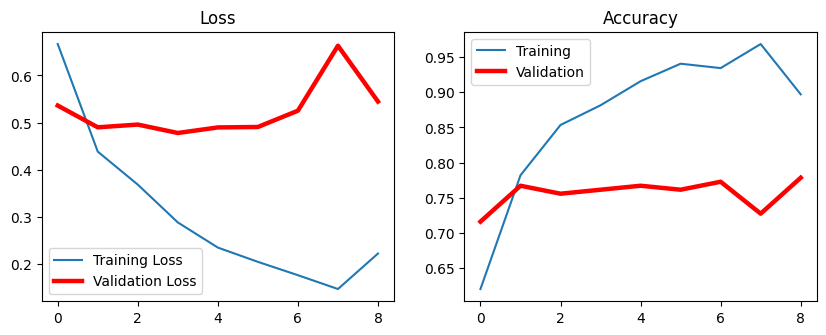

In [20]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

acc = model.evaluate(test_set, steps=len(test_set), verbose=0)
print('score = {:.3f}'.format(acc[1]))

In [21]:
def predict_dog_cat(lst):
  y_pred = []; y_pred_cls = []; img_lst = []
  for i in lst:
    img = load_img(i, target_size=(64,64))
    img = img_to_array(img)
    img /= 255.0
    img_lst.append(img)

    img = np.expand_dims(img, axis=0)
    y_pred_i = model.predict(img)
    y_pred_cls_i = 'Dog' if y_pred_i > 0.5 else 'Cat'
    y_pred.append(y_pred_i)
    y_pred_cls.append(y_pred_cls_i)

  return img_lst, y_pred_cls, y_pred

1/1 [==============================] - 0s 71ms/step


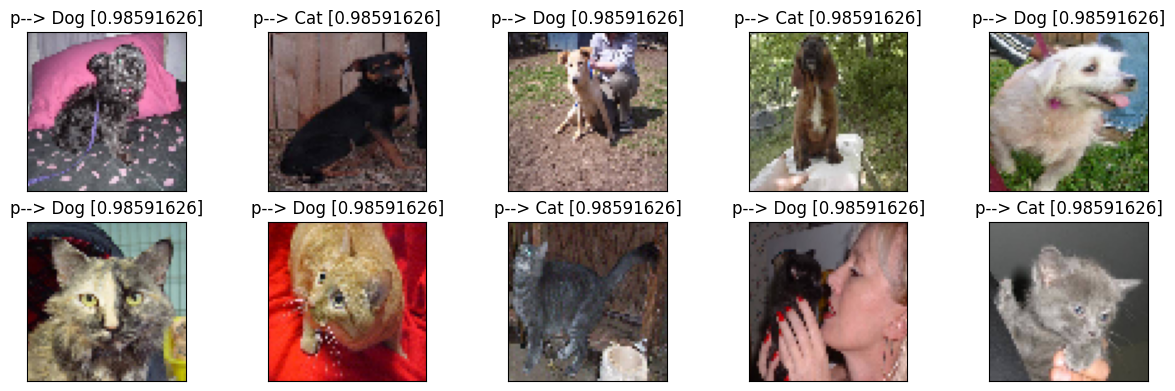

In [25]:
img_lst, y_pred_cls, y_pred = predict_dog_cat(['/content/dog.0.jpg', '/content/dog.18.jpg', '/content/dog.22.jpg', '/content/dog.5.jpg', '/content/dog.9.jpg', 
                                               '/content/cat.10.jpg', '/content/cat.18.jpg', '/content/cat.22.jpg', '/content/cat.26.jpg', '/content/cat.28.jpg'])

fig = plt.figure(figsize=(15, 7))
for i, k in enumerate(img_lst):
  plt.subplot(3, 5, i+1)
  plt.imshow(k, cmap=plt.cm.gray_r)
  plt.title('p--> {0} {1}'.format(y_pred_cls[i], y_pred[0][0]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# Workshop 2: ปรับแต่งด้วย Fine-tuning

In [27]:
base_model.trainable = True

for layer in base_model.layers[:-8]:
  layer.trainable = False

for variable in model.trainable_variables:
  print(variable.name)

block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,977,089
Trainable params: 13,241,601
Non-trainable params: 1,735,488
_________________________________________________________________


In [29]:
base_model.trainable = True

for layer in base_model.layers:
  if layer.name[:11] == 'block5_conv':
    layer.trainable = True
    print(layer.name, '--> True')
  else:
    layer.trainable = False
    print(layer.name, '--> False')

input_1 --> False
block1_conv1 --> False
block1_conv2 --> False
block1_pool --> False
block2_conv1 --> False
block2_conv2 --> False
block2_pool --> False
block3_conv1 --> False
block3_conv2 --> False
block3_conv3 --> False
block3_pool --> False
block4_conv1 --> False
block4_conv2 --> False
block4_conv3 --> False
block4_pool --> False
block5_conv1 --> True
block5_conv2 --> True
block5_conv3 --> True
block5_pool --> False


In [30]:
from tensorflow.keras.optimizers import Adam

In [34]:
opt = Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=test_set, 
                    validation_steps=len(test_set), 
                    epochs=20, verbose=1, callbacks=[es, mc])

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9720
Epoch 1: val_accuracy did not improve from 0.77841
11/11 [==============================] - 48s 4s/step - loss: 0.1152 - accuracy: 0.9720 - val_loss: 0.5514 - val_accuracy: 0.7784
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9938
Epoch 2: val_accuracy did not improve from 0.77841
11/11 [==============================] - 35s 3s/step - loss: 0.0626 - accuracy: 0.9938 - val_loss: 0.5911 - val_accuracy: 0.7557
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.77841
11/11 [==============================] - 44s 4s/step - loss: 0.0404 - accuracy: 1.0000 - val_loss: 0.6284 - val_accuracy: 0.7443
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.77841
11/11 [==========================

# Workshop 3: Transfer Learning จาก ResNet

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Deep Learning/tran dog cat/train', 
                                              target_size=(64,64), batch_size=32, class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Deep Learning/tran dog cat/test', 
                                            target_size=(64,64), batch_size=32, class_mode='binary')

Found 321 images belonging to 2 classes.
Found 176 images belonging to 2 classes.


In [37]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(64,64,3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,636,545
Trainable params: 24,583,425
Non-trainable params: 53,120
_________________________________________________________________


In [38]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set, validation_data=test_set, epochs=20, verbose=1, callbacks=[es, mc])

end = time.time()
print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.3744 - accuracy: 0.6760
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
11/11 [==============================] - 86s 6s/step - loss: 1.3744 - accuracy: 0.6760 - val_loss: 1.3112 - val_accuracy: 0.5000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8411
Epoch 2: val_accuracy did not improve from 0.50000
11/11 [==============================] - 60s 6s/step - loss: 0.3885 - accuracy: 0.8411 - val_loss: 4.8224 - val_accuracy: 0.5000
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9720
Epoch 3: val_accuracy did not improve from 0.50000
11/11 [==============================] - 60s 6s/step - loss: 0.0946 - accuracy: 0.9720 - val_loss: 9.7535 - val_accuracy: 0.5000
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9252
Epoch 4: val_accuracy did not improve from 0.50000
1

score = 0.500


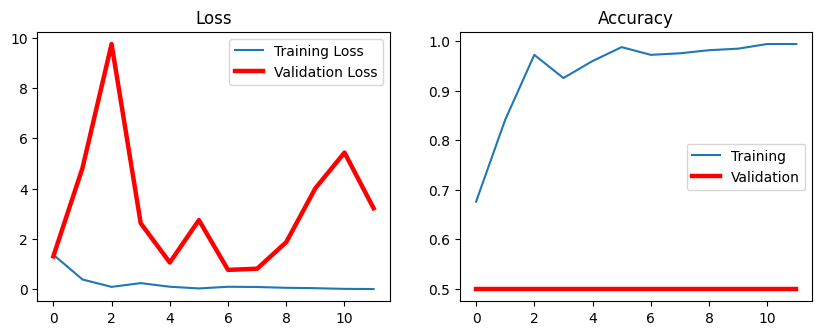

In [39]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

acc = model.evaluate(test_set, steps=len(test_set), verbose=0)
print('score = {:.3f}'.format(acc[1]))

# Workshop 4: Transfer Learning จำแนก สุนัข แมว ช้าง

## โหลดข้อมูลจาก Kaggle

In [42]:
!pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d shiv28/animal-5-mammal
! unzip animal-5-mammal.zip

Streaming output truncated to the last 5000 lines.
  inflating: Animal/train/cat/pixabay_cat_003879.jpg  
  inflating: Animal/train/cat/pixabay_cat_003880.jpg  
  inflating: Animal/train/cat/pixabay_cat_003881.jpg  
  inflating: Animal/train/cat/pixabay_cat_003882.jpg  
  inflating: Animal/train/cat/pixabay_cat_003883.jpg  
  inflating: Animal/train/cat/pixabay_cat_003884.jpg  
  inflating: Animal/train/cat/pixabay_cat_003885.jpg  
  inflating: Animal/train/cat/pixabay_cat_003886.jpg  
  inflating: Animal/train/cat/pixabay_cat_003887.jpg  
  inflating: Animal/train/cat/pixabay_cat_003888.jpg  
  inflating: Animal/train/cat/pixabay_cat_003889.jpg  
  inflating: Animal/train/cat/pixabay_cat_003891.jpg  
  inflating: Animal/train/cat/pixabay_cat_003892.jpg  
  inflating: Animal/train/cat/pixabay_cat_003893.jpg  
  inflating: Animal/train/cat/pixabay_cat_003894.jpg  
  inflating: Animal/train/cat/pixabay_cat_003895.jpg  
  inflating: Animal/train/cat/pixabay_cat_003897.jpg  
  inflating: A

## สร้าง Model

In [65]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_directory('/content/Animal/train', 
                                              target_size=(64,64), batch_size=32, class_mode='sparse')

val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory('/content/Animal/val', 
                                            target_size=(64,64), batch_size=32, class_mode='sparse')

Found 13496 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [66]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(64,64,3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 5)                

In [67]:
base_model.trainable = False

print("Trainable.\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable.
---
dense_20/kernel:0
dense_20/bias:0
dense_21/kernel:0
dense_21/bias:0
dense_22/kernel:0
dense_22/bias:0


In [68]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 5)                

In [69]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_modelcls.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set, validation_data=val_set, epochs=10, verbose=1, callbacks=[es, mc])

end = time.time()
print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/10
422/422 [==============================] - ETA: 0s - loss: 1.5766 - accuracy: 0.2738
Epoch 1: val_accuracy improved from -inf to 0.36933, saving model to best_modelcls.h5
422/422 [==============================] - 389s 768ms/step - loss: 1.5766 - accuracy: 0.2738 - val_loss: 1.4682 - val_accuracy: 0.3693
Epoch 2/10
422/422 [==============================] - ETA: 0s - loss: 1.4522 - accuracy: 0.3517
Epoch 2: val_accuracy improved from 0.36933 to 0.46000, saving model to best_modelcls.h5
422/422 [==============================] - 302s 715ms/step - loss: 1.4522 - accuracy: 0.3517 - val_loss: 1.3469 - val_accuracy: 0.4600
Epoch 3/10
422/422 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.3949
Epoch 3: val_accuracy improved from 0.46000 to 0.53267, saving model to best_modelcls.h5
422/422 [==============================] - 301s 712ms/step - loss: 1.3793 - accuracy: 0.3949 - val_loss: 1.2458 - val_accuracy: 0.5327
Epoch 4/10
422/422 [=======================

In [88]:
def predict_dog_cat(lst):
  y_pred = []; y_pred_cls = []; img_lst = []
  for i in lst:
    img = load_img(i, target_size=(64,64))
    img = img_to_array(img)
    img /= 255.0
    img_lst.append(img)

    img = np.expand_dims(img, axis=0)
    y_pred_i = model.predict(img)
    if np.argmax(y_pred_i) == 0:
      y_pred_cls_i = 'ELEPHANT'
    elif np.argmax(y_pred_i) == 1:
      y_pred_cls_i = 'HORSE'
    elif np.argmax(y_pred_i) == 2:
      y_pred_cls_i = 'LION'
    elif np.argmax(y_pred_i) == 3:
      y_pred_cls_i = 'CAT'
    else:
      y_pred_cls_i = 'DOG'
    y_pred.append(y_pred_i[0][np.argmax(y_pred_i)])
    y_pred_cls.append(y_pred_cls_i)

  return img_lst, y_pred_cls, y_pred

1/1 [==============================] - 0s 56ms/step


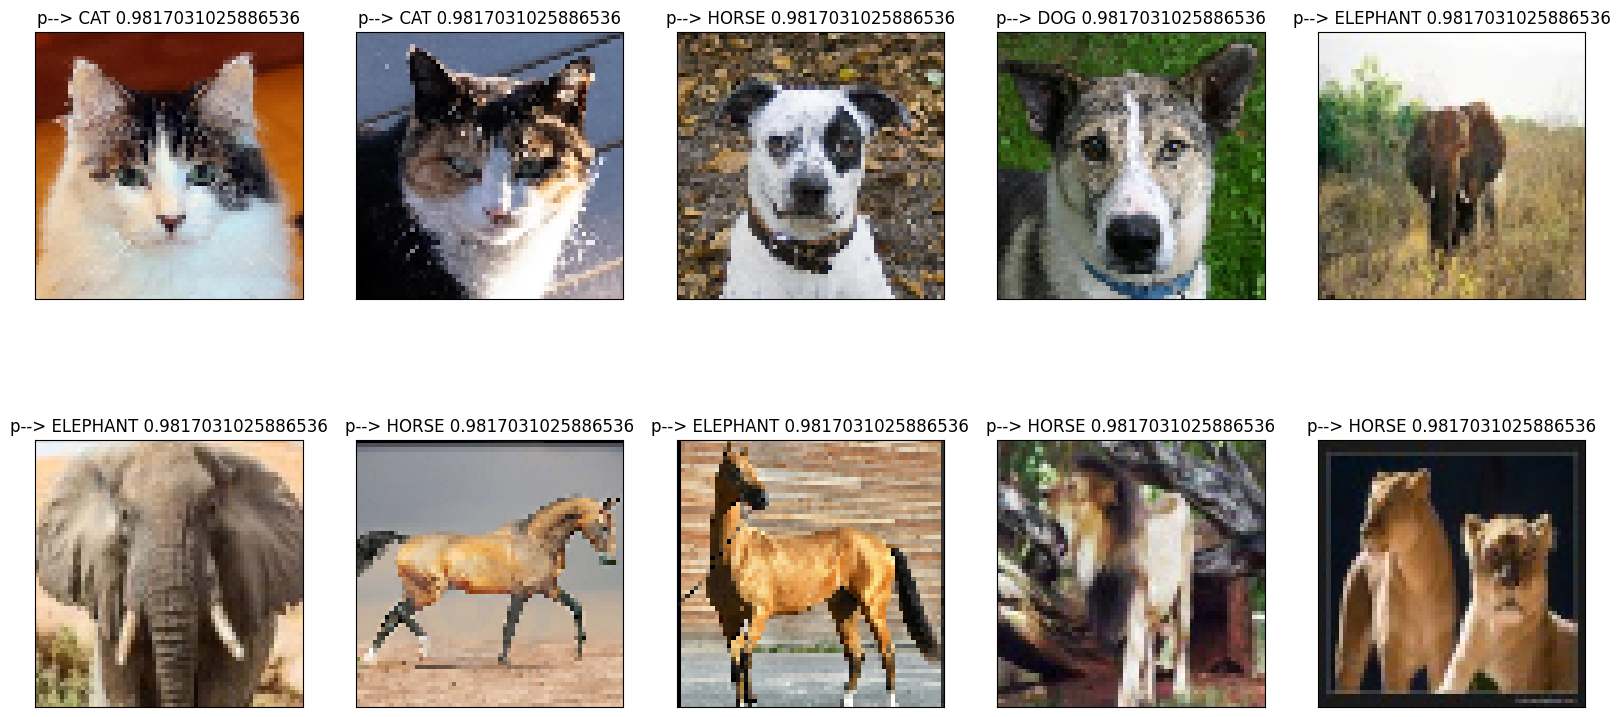

In [92]:
img_lst, y_pred_cls, y_pred = predict_dog_cat(['/content/Cat1.jpg', '/content/Cat2.jpg', '/content/Dog1.jpg', '/content/Dog2.jpg', '/content/Elephant1.jpg', 
                                               '/content/Elephant2.jpg', '/content/Horse1.png', '/content/Horse2.png', '/content/Lion1.jpg', '/content/Lion2.jpg'])

fig = plt.figure(figsize=(20, 15))
for i, k in enumerate(img_lst):
  plt.subplot(3, 5, i+1)
  plt.imshow(k, cmap=plt.cm.gray_r)
  plt.title('p--> {0} {1}'.format(y_pred_cls[i], y_pred[0]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# Workshop 5: Transfer Learning จาก MobileNet

In [96]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [97]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_directory('/content/Animal/train', 
                                              target_size=(64,64), batch_size=32, class_mode='sparse')

val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory('/content/Animal/val', 
                                            target_size=(64,64), batch_size=32, class_mode='sparse')

Found 13496 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


{'ELEPHANT': 0, 'HORSE': 1, 'LION': 2, 'cat': 3, 'dog': 4}
(32, 64, 64, 3)
(32,)
0.0 0.5
class: 3.0


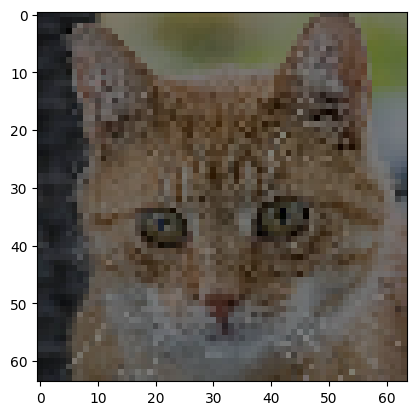

In [101]:
print(train_set.class_indices)
for image_batch, label_batch in train_set:
  print(image_batch.shape)
  print(label_batch.shape)

  img = image_batch[0] - image_batch[0].min()
  img /= 2.0
  print(img.min(), img.max())
  plt.imshow(img)
  print('class:', label_batch[0])
  break

In [102]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64,64,3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_9 (Flatten)         (None, 5120)              0         
                                                                 
 dense_23 (Dense)            (None, 256)               1310976   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0 

In [103]:
base_model.trainable = False

print("Trainable.\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable.
---
dense_23/kernel:0
dense_23/bias:0
dense_24/kernel:0
dense_24/bias:0
dense_25/kernel:0
dense_25/bias:0


In [104]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_9 (Flatten)         (None, 5120)              0         
                                                                 
 dense_23 (Dense)            (None, 256)               1310976   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                      

In [105]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_modelcls.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set, validation_data=val_set, epochs=10, verbose=1, callbacks=[es, mc])

end = time.time()
print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/10
422/422 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.7177
Epoch 1: val_accuracy improved from -inf to 0.81333, saving model to best_modelcls.h5
422/422 [==============================] - 121s 277ms/step - loss: 0.8482 - accuracy: 0.7177 - val_loss: 0.4730 - val_accuracy: 0.8133
Epoch 2/10
422/422 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.8033
Epoch 2: val_accuracy improved from 0.81333 to 0.84533, saving model to best_modelcls.h5
422/422 [==============================] - 118s 280ms/step - loss: 0.5536 - accuracy: 0.8033 - val_loss: 0.4261 - val_accuracy: 0.8453
Epoch 3/10
422/422 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8317
Epoch 3: val_accuracy improved from 0.84533 to 0.85200, saving model to best_modelcls.h5
422/422 [==============================] - 118s 279ms/step - loss: 0.4588 - accuracy: 0.8317 - val_loss: 0.3980 - val_accuracy: 0.8520
Epoch 4/10
422/422 [=======================

In [106]:
def predict_dog_cat(lst):
  y_pred = []; y_pred_cls = []; img_lst = []
  for i in lst:
    img = load_img(i, target_size=(64,64))
    img = img_to_array(img)
    img /= 255.0
    img_lst.append(img)

    img = np.expand_dims(img, axis=0)
    y_pred_i = model.predict(img)
    if np.argmax(y_pred_i) == 0:
      y_pred_cls_i = 'ELEPHANT'
    elif np.argmax(y_pred_i) == 1:
      y_pred_cls_i = 'HORSE'
    elif np.argmax(y_pred_i) == 2:
      y_pred_cls_i = 'LION'
    elif np.argmax(y_pred_i) == 3:
      y_pred_cls_i = 'CAT'
    else:
      y_pred_cls_i = 'DOG'
    y_pred.append(y_pred_i[0][np.argmax(y_pred_i)])
    y_pred_cls.append(y_pred_cls_i)

  return img_lst, y_pred_cls, y_pred

1/1 [==============================] - 0s 49ms/step


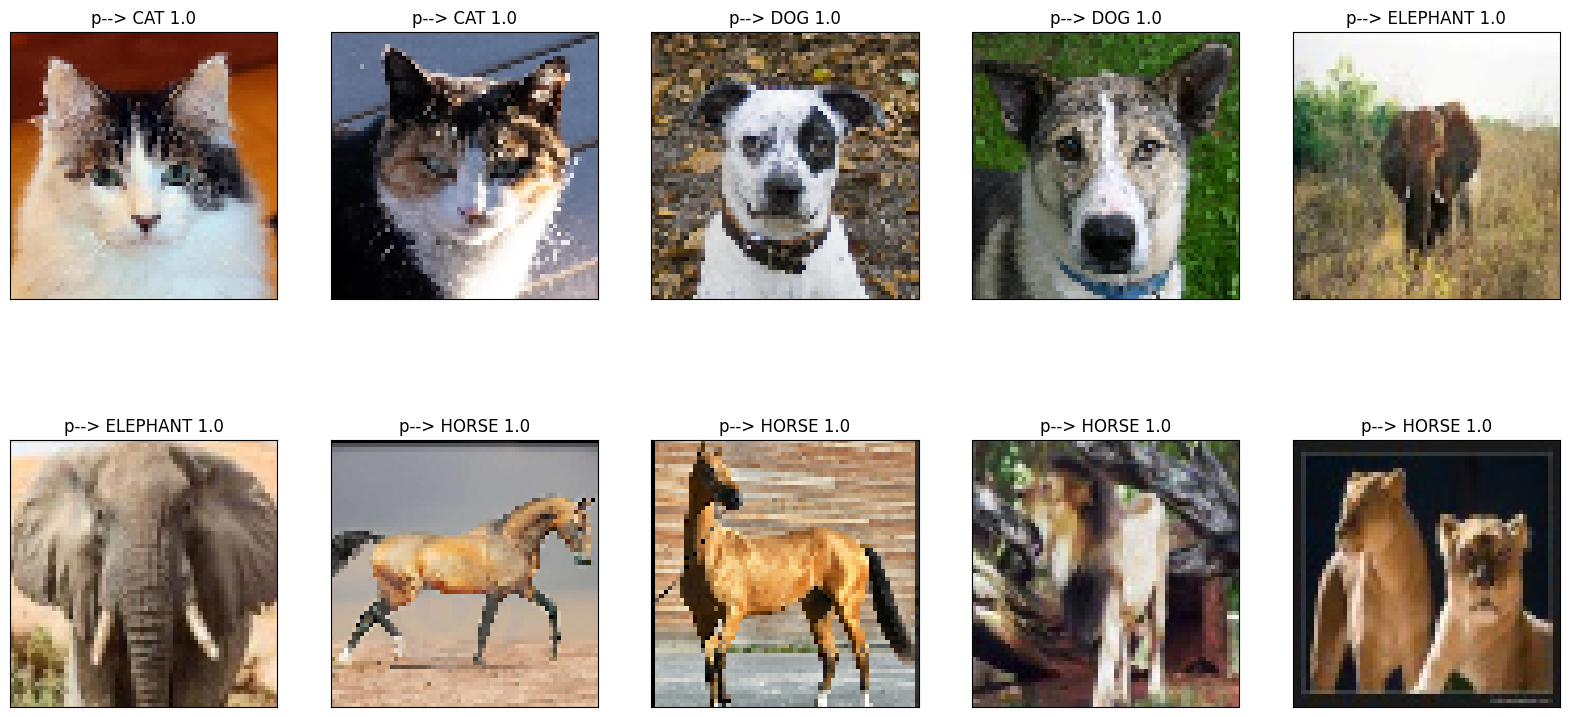

In [107]:
img_lst, y_pred_cls, y_pred = predict_dog_cat(['/content/Cat1.jpg', '/content/Cat2.jpg', '/content/Dog1.jpg', '/content/Dog2.jpg', '/content/Elephant1.jpg', 
                                               '/content/Elephant2.jpg', '/content/Horse1.png', '/content/Horse2.png', '/content/Lion1.jpg', '/content/Lion2.jpg'])

fig = plt.figure(figsize=(20, 15))
for i, k in enumerate(img_lst):
  plt.subplot(3, 5, i+1)
  plt.imshow(k, cmap=plt.cm.gray_r)
  plt.title('p--> {0} {1}'.format(y_pred_cls[i], y_pred[0]))
  plt.xticks([])
  plt.yticks([])
plt.show()